<font color='tomato'><font color="#CC3D3D"><p>
# Conv1D based Model

<img src='http://drive.google.com/uc?export=view&id=1mJrrYAhszKsv7WZU7yzVWFMuU-Hl5IhK' width=700 height=500/>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print(tf.__version__)

# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(seed, reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print(f"Random seeds reset: {seed}")  # optional
   
reset_seeds(415)

2.1.2
Random seeds reset: 415


Using TensorFlow backend.


### Read Data

In [2]:
df_train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
df_test = pd.read_csv(os.path.abspath("../dat")+'/test_transactions.csv', encoding='cp949')
y_train = pd.read_csv(os.path.abspath("../dat")+'/y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


In [3]:
# len(df_train)

232004

In [4]:
# df_train.query("gds_grp_nm == '상품군미지정'")['amount']#.describe()

4           20000
15           1480
20           2960
24           4000
43           1610
           ...   
231987    -120000
231991    1208000
231994     265500
231996     260000
231999    -135000
Name: amount, Length: 40753, dtype: int64

In [5]:
# df_train_환불 = df_train.query("gds_grp_mclas_nm == '기타'").query("amount < 0")
# df_train_환불['gds_grp_nm'] = '환불'
# df_train_환불['gds_grp_mclas_nm'] = '기타1'; df_train_환불

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
532,13,2007-08-23 00:00:00,분당점,381202,환불,기타1,-79000
539,13,2007-10-22 00:00:00,분당점,241110,환불,기타1,-342720
610,14,2007-03-20 00:00:00,본 점,443167,환불,기타1,-2500
1111,15,2007-07-18 00:00:00,본 점,221208,환불,기타1,-139000
1244,15,2007-10-05 00:00:00,본 점,173227,환불,기타1,-95000
...,...,...,...,...,...,...,...
231112,3472,2007-12-06 00:00:00,노원점,241110,환불,기타1,-152600
231200,3474,2007-12-05 00:00:00,부산본점,124101,환불,기타1,-68000
231285,3476,2007-12-12 00:00:00,전주점,241210,환불,기타1,-89000
231987,3499,2007-10-13 00:00:00,본 점,124101,환불,기타1,-120000


In [6]:
# df_train_상품군미지정1 = df_train.query("gds_grp_mclas_nm == '기타'").query("0 <=amount < 10000")
# df_train_상품군미지정1['gds_grp_nm'] = '상품군미지정1'
# df_train_상품군미지정1['gds_grp_mclas_nm'] = '기타1'; df_train_상품군미지정1

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
15,0,2007-07-11 00:00:00,강남점,51102,상품군미지정1,기타1,1480
20,0,2007-07-11 00:00:00,강남점,43111,상품군미지정1,기타1,2960
24,0,2007-07-11 00:00:00,강남점,26165,상품군미지정1,기타1,4000
43,0,2007-09-08 00:00:00,강남점,26165,상품군미지정1,기타1,1610
55,0,2007-10-28 00:00:00,강남점,26165,상품군미지정1,기타1,1150
...,...,...,...,...,...,...,...
231928,3499,2007-05-20 00:00:00,본 점,996101,상품군미지정1,기타1,1250
231936,3499,2007-05-30 00:00:00,본 점,996101,상품군미지정1,기타1,1250
231944,3499,2007-06-10 00:00:00,본 점,996101,상품군미지정1,기타1,2500
231968,3499,2007-08-22 00:00:00,본 점,996101,상품군미지정1,기타1,2500


In [7]:
# df_train_상품군미지정2 = df_train.query("gds_grp_mclas_nm == '기타'").query("10000 <=amount < 100000")
# df_train_상품군미지정2['gds_grp_nm'] = '상품군미지정2'
# df_train_상품군미지정2['gds_grp_mclas_nm'] = '기타2'; df_train_상품군미지정2

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정2,기타2,20000
46,0,2007-09-08 00:00:00,강남점,47104,상품군미지정2,기타2,28000
51,0,2007-10-18 00:00:00,강남점,342220,상품군미지정2,기타2,30000
54,0,2007-10-28 00:00:00,강남점,111204,상품군미지정2,기타2,10000
63,0,2007-11-05 00:00:00,강남점,117202,상품군미지정2,기타2,10000
...,...,...,...,...,...,...,...
231946,3499,2007-06-10 00:00:00,본 점,26165,상품군미지정2,기타2,32000
231966,3499,2007-08-22 00:00:00,본 점,26165,상품군미지정2,기타2,32000
231970,3499,2007-09-03 00:00:00,본 점,47103,상품군미지정2,기타2,96000
231972,3499,2007-09-03 00:00:00,본 점,26165,상품군미지정2,기타2,32000


In [8]:
# df_train_상품군미지정3 = df_train.query("gds_grp_mclas_nm == '기타'").query("100000 <=amount < 1000000")
# df_train_상품군미지정3['gds_grp_nm'] = '상품군미지정3'
# df_train_상품군미지정3['gds_grp_mclas_nm'] = '기타3'; df_train_상품군미지정3

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
58,0,2007-10-28 00:00:00,강남점,342120,상품군미지정3,기타3,179000
71,0,2007-12-15 00:00:00,잠실점,124101,상품군미지정3,기타3,190000
110,3,2007-06-10 00:00:00,광주점,173127,상품군미지정3,기타3,179000
153,7,2007-01-20 00:00:00,본 점,73119,상품군미지정3,기타3,102000
157,7,2007-02-13 00:00:00,본 점,73151,상품군미지정3,기타3,207000
...,...,...,...,...,...,...,...
231922,3499,2007-04-14 00:00:00,노원점,381101,상품군미지정3,기타3,271200
231940,3499,2007-06-08 00:00:00,일산점,173127,상품군미지정3,기타3,434000
231980,3499,2007-10-12 00:00:00,본 점,124101,상품군미지정3,기타3,308000
231994,3499,2007-12-16 00:00:00,본 점,173127,상품군미지정3,기타3,265500


In [9]:
# df_train_상품군미지정4 = df_train.query("gds_grp_mclas_nm == '기타'").query("1000000 <=amount")
# df_train_상품군미지정4['gds_grp_nm'] = '상품군미지정4'
# df_train_상품군미지정4['gds_grp_mclas_nm'] = '기타4'; df_train_상품군미지정4

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
126,4,2007-11-14 00:00:00,본 점,150124,상품군미지정4,기타4,3000000
4512,32,2007-01-05 00:00:00,본 점,462106,상품군미지정4,기타4,1201200
7122,55,2007-10-06 00:00:00,안양점,342120,상품군미지정4,기타4,1053000
7654,68,2007-04-03 00:00:00,대전점,365117,상품군미지정4,기타4,1044000
7667,68,2007-04-13 00:00:00,대전점,365117,상품군미지정4,기타4,1331700
...,...,...,...,...,...,...,...
229695,3446,2007-04-27 00:00:00,분당점,361106,상품군미지정4,기타4,1153000
229707,3446,2007-05-03 00:00:00,분당점,361106,상품군미지정4,기타4,1370000
229896,3446,2007-11-09 00:00:00,분당점,361106,상품군미지정4,기타4,1055000
231485,3487,2007-01-29 00:00:00,분당점,150109,상품군미지정4,기타4,1260000


In [10]:
# df_train = df_train.drop(index = df_train_환불.index)
# df_train = df_train.drop(index = df_train_상품군미지정1.index)
# df_train = df_train.drop(index = df_train_상품군미지정2.index)
# df_train = df_train.drop(index = df_train_상품군미지정3.index)
# df_train = df_train.drop(index = df_train_상품군미지정4.index)

In [11]:
# df_train = pd.concat([df_train, df_train_환불,df_train_상품군미지정1,df_train_상품군미지정2,df_train_상품군미지정3,df_train_상품군미지정4])

In [12]:
# df_train = df_train.sort_index(ascending=True)

In [13]:
# df_train1['tran_date']

0         2007-01-19 00:00:00
1         2007-03-30 00:00:00
2         2007-03-30 00:00:00
3         2007-03-30 00:00:00
4         2007-03-30 00:00:00
                 ...         
231999    2007-12-17 00:00:00
232000    2007-12-23 00:00:00
232001    2007-12-23 00:00:00
232002    2007-12-27 00:00:00
232003    2007-12-27 00:00:00
Name: tran_date, Length: 232004, dtype: object

In [14]:
# df_train['tran_date'] = df_train1['tran_date']; df_train

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정2,기타2,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,환불,기타1,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


### Transform Data

In [3]:
max_features = 100000
max_len = 100
emb_dim = 128

##### low level: goods_id

In [4]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

##### middle level: gds_grp_nm

In [5]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

##### high level: gds_grp_mclas_nm

In [6]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

##### store

In [7]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [keras.preprocessing.text.one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

##### weekday

In [8]:
# Converts a "tran_date" to a sequence of indexes in a fixed-size hashing space
df_train.tran_date = pd.to_datetime(df_train.tran_date).dt.weekday
df_test.tran_date = pd.to_datetime(df_test.tran_date).dt.weekday
X_train = df_train.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values
X_test = df_test.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values

# Pads sequences to the same length
X_train_day = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test_day = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

X_train_day.shape, X_test_day.shape

((3500, 100), (2482, 100))

### Build Models

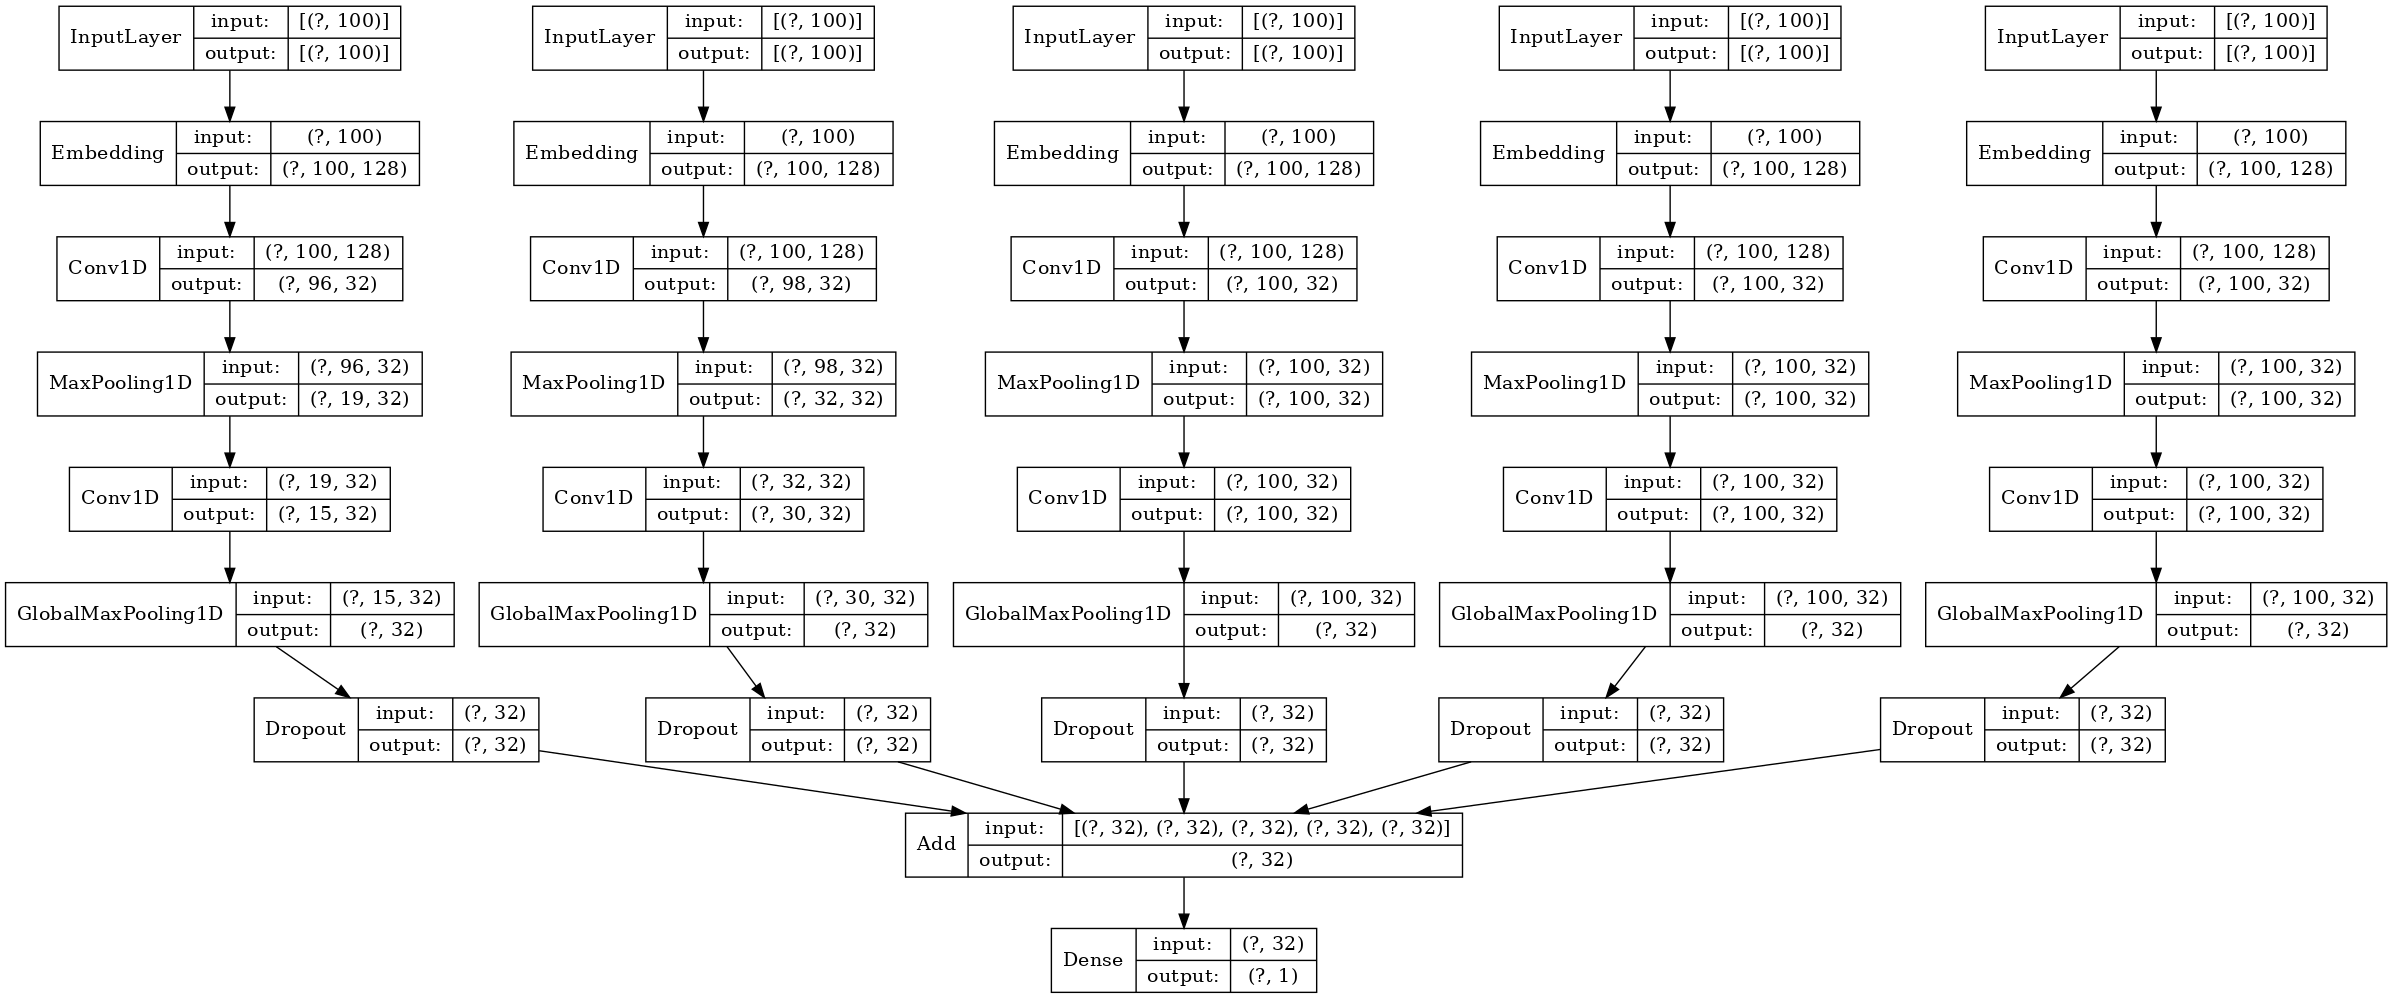

In [9]:
# Define the Model & its Architecture

in_low = keras.Input(shape=(max_len,), dtype='int32', name='low')
x = keras.layers.Embedding(max_features, emb_dim)(in_low)
x = keras.layers.Conv1D(32, 5, activation='elu')(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(32, 5, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_low = keras.layers.Dropout(0.5)(x)

in_mid = keras.Input(shape=(max_len,), dtype='int32', name='mid')
x = keras.layers.Embedding(max_features//10, emb_dim)(in_mid)
x = keras.layers.Conv1D(32, 3, activation='elu')(x)
x = keras.layers.MaxPooling1D(3)(x)
x = keras.layers.Conv1D(32, 3, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_mid = keras.layers.Dropout(0.5)(x)

in_high = keras.Input(shape=(max_len,), dtype='int32', name='high')
x = keras.layers.Embedding(max_features//100, emb_dim)(in_high)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_high = keras.layers.Dropout(0.5)(x)

in_str = keras.Input(shape=(max_len,), dtype='int32', name='store')
x = keras.layers.Embedding(max_features//100, emb_dim)(in_str)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_str = keras.layers.Dropout(0.5)(x)

in_day = keras.Input(shape=(max_len,), dtype='int32', name='day')
x = keras.layers.Embedding(7, emb_dim)(in_day)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.MaxPooling1D(1)(x)
x = keras.layers.Conv1D(32, 1, activation='elu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
out_day = keras.layers.Dropout(0.5)(x)

x = keras.layers.add([out_low, out_mid, out_high, out_str, out_day], name='my_layer')
out = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model([in_low, in_mid, in_high, in_str, in_day], out)
Image(keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

In [ ]:
# Choose the Optimizer and the Cost function
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(name='roc_auc')])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day], y_train, 
                    epochs=50, batch_size=64,
                    validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=7)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 8s 3ms/sample - loss: 0.6564 - roc_auc: 0.5713 - val_loss: 0.6448 - val_roc_auc: 0.6364
Epoch 2/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6379 - roc_auc: 0.6363 - val_loss: 0.6381 - val_roc_auc: 0.6461
Epoch 3/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6316 - roc_auc: 0.6483 - val_loss: 0.6331 - val_roc_auc: 0.6578
Epoch 4/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6247 - roc_auc: 0.6649 - val_loss: 0.6288 - val_roc_auc: 0.6675
Epoch 5/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6217 - roc_auc: 0.6695 - val_loss: 0.6241 - val_roc_auc: 0.6769
Epoch 6/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6110 - roc_auc: 0.6939 - val_loss: 0.6189 - val_roc_auc: 0.6855
Epoch 7/50
2800/2800 [==============================] - 6s 2ms/sample - loss: 0.6101 - ro

### Make Submissions

In [23]:
pred = model.predict([X_test_low, X_test_mid, X_test_high, X_test_str, X_test_day]).flatten()
t = pd.Timestamp.now()
fname = f"Conv1D_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'Conv1D_submission_12121518.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End